# Compute KDE from MCMC chains

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from lace_manager.sampler import emcee_sampler
from lace_manager.likelihood import marg_p1d_like

### Load a single sampler, and plot posteriors

In [2]:
rootdir='/Users/font/Projects/LaCE_manager/lace_manager/sampler/chains/'
subfolder=None

In [3]:
sampler=emcee_sampler.EmceeSampler(read_chain_file=6,
                                subfolder=subfolder,rootdir=rootdir,
                                train_when_reading=True,
                                verbose=True)

will read chain from file 6
Building archive
Setting up emulator
Loading emulator using a specific archive, not the one set in basedir
Rescaled params to unity volume
Training GP on 330 points


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.22 seconds
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00
Setting up likelihood
Load sampler data


will keep 26414 \ 27400 points from chain


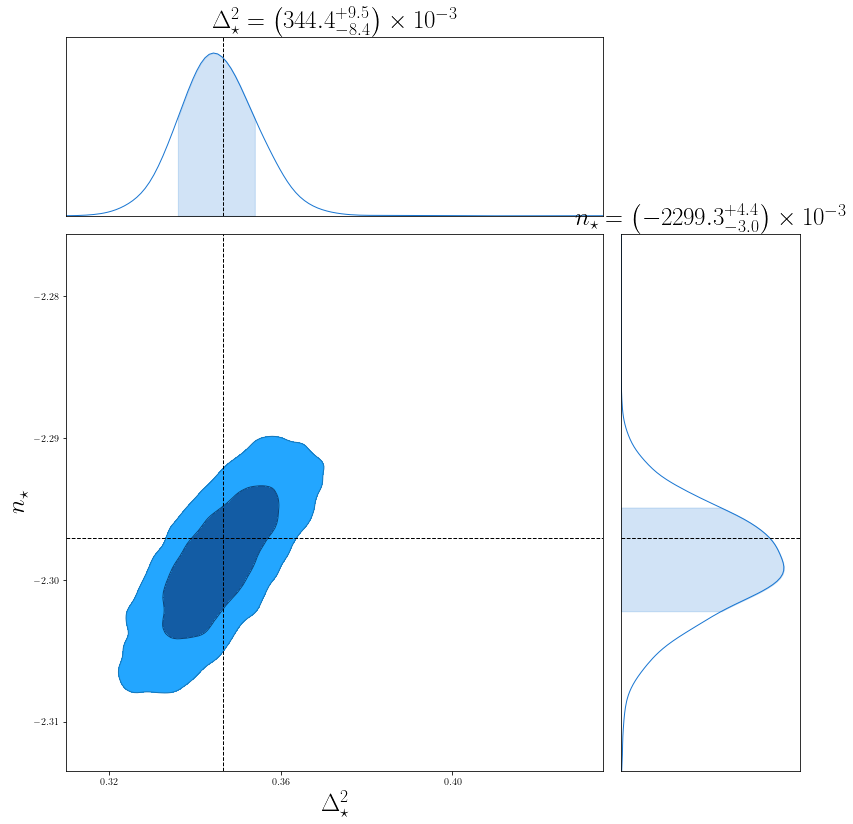

In [4]:
#plot_params=['$A_s$','$n_s$','$\Delta^2_\star$','$n_\star$']
plot_params=['$\Delta^2_\star$','$n_\star$']
sampler.plot_corner(delta_lnprob_cut=50,plot_params=plot_params)

# Setup KDE from chain

In [5]:
chain,lnprob,blobs=sampler.get_chain(cube=False,delta_lnprob_cut=50)

will keep 26414 \ 27400 points from chain


In [6]:
x=blobs['Delta2_star']
y=blobs['n_star']
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
print('{:.3f} < Delta2_star < {:.3f}'.format(xmin,xmax))
print('{:.3f} < n_star < {:.3f}'.format(ymin,ymax))

0.293 < Delta2_star < 0.452
-2.316 < n_star < -2.276


In [7]:
mean_D2_star=np.mean(x)
mean_n_star=np.mean(y)
print('Delta2_star (mean) =',mean_D2_star)
print('n_star (mean) =',mean_n_star)

Delta2_star (mean) = 0.34547663139245033
n_star (mean) = -2.2988117365772824


In [8]:
max_lnprob=np.max(lnprob)
imax=np.where(lnprob==max_lnprob)
max_like_D2_star=x[imax][0]
max_like_n_star=y[imax][0]
print('Delta2_star (max like) =',max_like_D2_star)
print('n_star (max like) =',max_like_n_star)

Delta2_star (max like) = 0.3458245588876878
n_star (max like) = -2.298673903707106


In [9]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

In [10]:
# best-fit values from KDE
kde_max_D2_star=X[Z==np.max(Z)][0]
kde_max_n_star=Y[Z==np.max(Z)][0]
print('Delta2_star (KDE) =',kde_max_D2_star)
print('n_star (KDE) =',kde_max_n_star)

Delta2_star (KDE) = 0.3445045142733838
n_star (KDE) = -2.2991540225013236


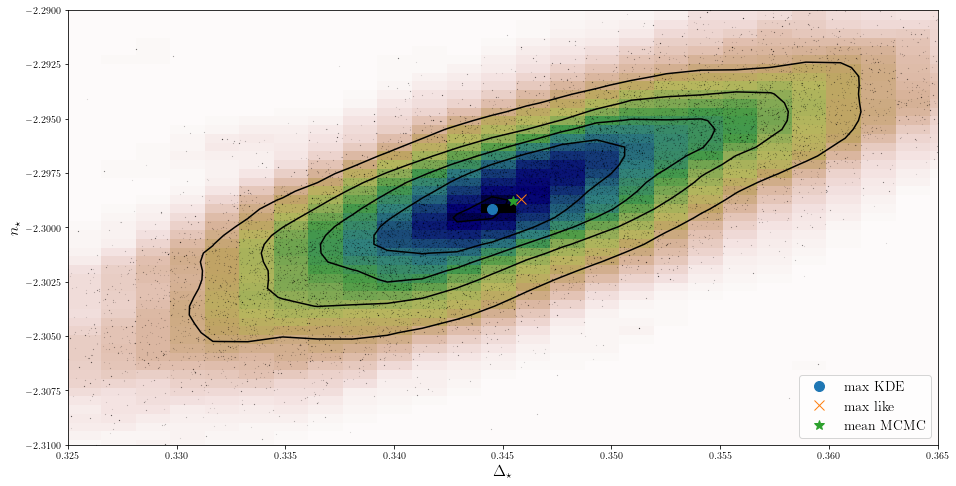

In [11]:
plt.figure(figsize=[16,8])
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax],label='density')
plt.plot(x, y, 'k.', markersize=0.1)
plt.contour(X,Y,Z,5,colors='k')
plt.plot(kde_max_D2_star,kde_max_n_star,'o',markersize=10,label='max KDE')
plt.plot(max_like_D2_star,max_like_n_star,'x',markersize=10,label='max like')
plt.plot(mean_D2_star,mean_n_star,'*',markersize=10,label='mean MCMC')
plt.xlim(0.325,0.365)
plt.ylim(-2.31,-2.29)
plt.xlabel(r'$\Delta_\star$',fontsize=16)
plt.ylabel(r'$n_\star$',fontsize=16)
plt.legend(fontsize=14)
#plt.colorbar()

# Interpolate on KDE

In [12]:
from scipy import interpolate

In [13]:
# make copy of KDE
newZ=np.copy(Z)
newX=np.copy(X)
newY=np.copy(Y)

In [14]:
kde_interp=interpolate.RectBivariateSpline(np.unique(newX),np.unique(newY),newZ)

In [15]:
# evaluate KDE on new grid
Nj=500j
X2, Y2 = np.mgrid[xmin:xmax:Nj, ymin:ymax:Nj]
Z2=kde_interp.ev(X2,Y2)

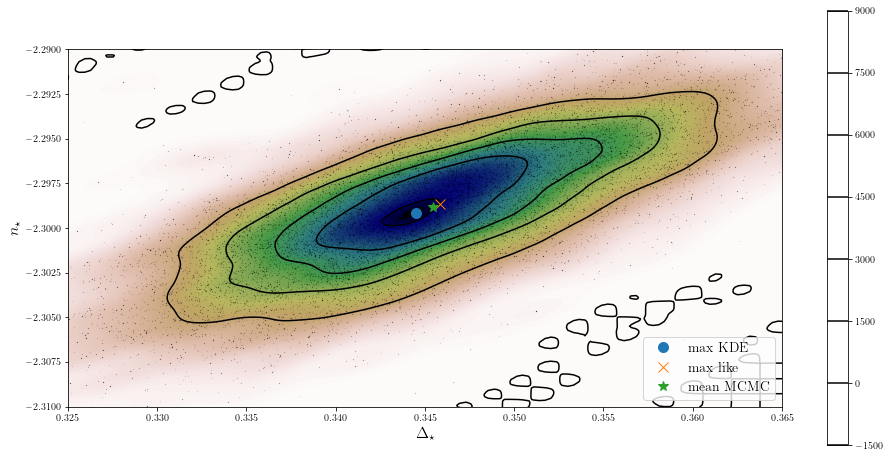

In [16]:
plt.figure(figsize=[16,8])
plt.imshow(np.rot90(Z2), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax],label='density')
plt.plot(x, y, 'k.', markersize=0.1)
plt.contour(X2,Y2,Z2,5,colors='k')
plt.plot(kde_max_D2_star,kde_max_n_star,'o',markersize=10,label='max KDE')
plt.plot(max_like_D2_star,max_like_n_star,'x',markersize=10,label='max like')
plt.plot(mean_D2_star,mean_n_star,'*',markersize=10,label='mean MCMC')
plt.xlim(0.325,0.365)
plt.ylim(-2.31,-2.29)
plt.xlabel(r'$\Delta_\star$',fontsize=16)
plt.ylabel(r'$n_\star$',fontsize=16)
plt.legend(fontsize=14)
plt.colorbar()

# Read / Write KDE from / to file

In [17]:
def write_KDE(sampler,fname,Nj=100j,delta_lnprob_cut=100,bw_method=None):
    # get chain points and probabilities
    chain,lnprob,blobs=sampler.get_chain(cube=False,delta_lnprob_cut=delta_lnprob_cut)
    # read compressed parameters and set range
    x=blobs['Delta2_star']
    y=blobs['n_star']
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    print('{:.3f} < Delta2_star < {:.3f}'.format(xmin,xmax))
    print('{:.3f} < n_star < {:.3f}'.format(ymin,ymax))
    # maximum likelihood points
    max_lnprob=np.max(lnprob)
    print('max lnprob',max_lnprob)
    imax=np.where(lnprob==max_lnprob)
    max_like_D2_star=x[imax][0]
    max_like_n_star=y[imax][0]
    print('Delta2_star (max like) =',max_like_D2_star)
    print('n_star (max like) =',max_like_n_star)
    # setup regular 2D grid for KDE
    X, Y = np.mgrid[xmin:xmax:Nj, ymin:ymax:Nj]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values,bw_method=bw_method)
    Z = np.reshape(kernel(positions).T, X.shape)
    # max-like values from KDE
    kde_max_D2_star=X[Z==np.max(Z)][0]
    kde_max_n_star=Y[Z==np.max(Z)][0]
    print('Delta2_star (max KDE) =',kde_max_D2_star)
    print('n_star (max KDE) =',kde_max_n_star)
    # store to file
    np.savez('{}.npz'.format(fname), Delta2_star=np.unique(X),
             n_star=np.unique(Y), counts_kde=Z)

In [18]:
def read_KDE(fname):
    data = np.load('{}.npz'.format(fname))
    Delta2_star=data['Delta2_star']
    n_star=data['n_star']
    counts=data['counts_kde']
    return Delta2_star, n_star, counts

In [19]:
write_KDE(sampler,fname='test_kde',Nj=100j,delta_lnprob_cut=50,bw_method=None)

will keep 26414 \ 27400 points from chain
0.293 < Delta2_star < 0.452
-2.316 < n_star < -2.276
max lnprob 178.32144836886184
Delta2_star (max like) = 0.3458245588876878
n_star (max like) = -2.298673903707106
Delta2_star (max KDE) = 0.3445045142733838
n_star (max KDE) = -2.2991540225013236


In [20]:
Delta2_star, n_star, counts = read_KDE('test_kde')

Text(0.5, 1.0, 'normalised counts')

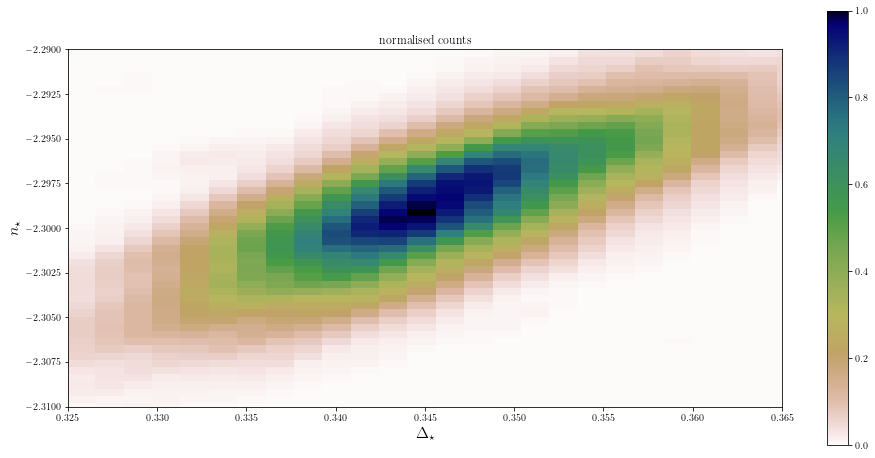

In [21]:
max_counts=np.max(counts)
plt.figure(figsize=[16,8])
plt.imshow(np.rot90(counts/max_counts), cmap=plt.cm.gist_earth_r,
           extent=[np.min(Delta2_star),np.max(Delta2_star),
                   np.min(n_star),np.max(n_star)])
plt.xlabel(r'$\Delta_\star$',fontsize=16)
plt.ylabel(r'$n_\star$',fontsize=16)
plt.xlim(0.325,0.365)
plt.ylim(-2.31,-2.29)
plt.colorbar()
plt.title('normalised counts')

# Use new KDE object

In [22]:
from lace_manager.likelihood import marg_p1d_like

In [23]:
sampler.write_kde(delta_lnprob_cut=25,N=20)

will print KDE to /Users/font/Projects/LaCE_manager/lace_manager/sampler/chains//chain_6/kde.npz
will keep 26337 \ 27400 points from chain
0.308 < Delta2_star < 0.389
-2.313 < n_star < -2.279
Delta2_star (max like) = 0.346
n_star (max like) = -2.299


In [24]:
kde_fname='/Users/font/Projects/LaCE_manager/lace_manager/sampler/chains/chain_6/kde.npz'
#kde_fname='/Users/font/Projects/LaCE_manager/notebooks/example_kde.npz'
marg_p1d=marg_p1d_like.MargP1DLike(kde_fname=kde_fname)

will setup marg_p1d from KDE file /Users/font/Projects/LaCE_manager/lace_manager/sampler/chains/chain_6/kde.npz


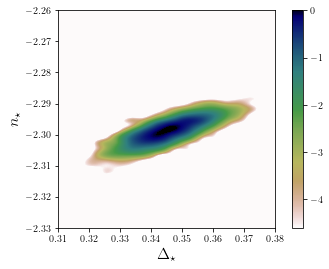

In [25]:
marg_p1d.plot_log_like(min_Delta2_star=0.31,max_Delta2_star=0.38)